## **Portfolio Optimization**

- We create a portfolio using the Riskfolio library.
- Asset statistics are calculated based on historical data.
- The Mean-Variance model is used for portfolio optimization.
- Our objective is to maximize the Sharpe ratio, balancing risk and return.

The portfolio return (expected return) using the Mean-Variance model is calculated as the weighted sum of the expected returns of individual assets:

$$E(R_p) = w_1 \cdot E(R_1) + w_2 \cdot E(R_2) + \ldots + w_n \cdot E(R_n)$$

The Sharpe ratio, a key measure for portfolio optimization, is calculated as:

$$\text{Sharpe Ratio (SR)} = \frac{E(R_p - R_f)}{\sigma_p}$$


This formula quantifies the excess return of the portfolio (over the risk-free rate) relative to its risk (volatility). A higher Sharpe ratio indicates a better risk-adjusted performance.


## **Efficient Frontier**

- The efficient frontier is a set of portfolios that offer the highest expected return for a given level of risk. It is represented by a curve in a graph where the x-axis represents the risk (standard deviation of the portfolio return) and the y-axis represents the return (expected portfolio return).



In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [15]:
%%capture
!pip install riskfolio-lib

In [16]:
mutual_funds_data= pd.read_csv('/kaggle/input/mutual-funds-and-etfs/MutualFund prices - A-E.csv')

In [17]:
random_state = np.random.RandomState(42)
unique_fund_symbols = mutual_funds_data.fund_symbol.unique()
chosen_symbols = random_state.choice(unique_fund_symbols, 9)


assets = chosen_symbols
val = []

prices_df = mutual_funds_data
## HOW MANY DAYS TO CONSIDER IN CALCULATING RETURNS
trade_days = 100
period = 1

for asset in assets:
    asset_df = prices_df[prices_df['fund_symbol'] == asset]
    nav_per_share = np.array(asset_df['nav_per_share'].iloc[:trade_days])    
    val.append(nav_per_share)

In [18]:
returns = pd.DataFrame(np.array(val).T, columns= assets).pct_change(periods=period)
returns = returns.dropna()
expected_returns = np.array(returns.mean())
sigma = np.array(returns.cov())

In [19]:
Y = returns

display(Y.head())

,AMMIX,DCGVX,CLPAX,AFAZX,DVIPX,CSCZX,CMNZX,CHCRX,ABAEX
1,0.000000,0.003744,-0.008040,0.000000,0.006000,-0.006444,0.000000,0.000000,-0.013986
2,0.001000,0.006631,0.004053,0.012484,-0.001988,-0.004864,0.000000,-0.004959,-0.013171
3,0.000999,0.009057,0.000000,0.012330,0.001992,-0.002851,0.000000,0.001661,0.016427
4,0.006986,-0.011832,-0.001009,0.009744,-0.002982,0.004902,-0.001832,0.009950,-0.007071
5,-0.003964,-0.001652,0.007071,0.006031,-0.002991,0.002033,-0.001835,-0.011494,-0.020346


### CLASSICAL MEAN VARIANCE OPTIMIZATION PROBLEM FORMULATION

Maximum Sharpe Ratio Portfolio with Weights ($w$) and Covariance Matrix ($\Sigma$):

$$
\begin{align*}
\text{Maximize} \quad & \frac{R(w) - rf}{\sqrt{w^T \Sigma w}} \\
\text{Subject to} \quad & A \cdot w \geq B \\
& R(w) \geq \bar{\mu}
\end{align*}
$$

WE WILL OPTIMIZE THIS USING THE LIBRARY RISKFOLIO


## RUNNING PORTFOLIO OPTIMIZATION

In [20]:
import riskfolio as rp
port = rp.Portfolio(returns=Y)

## THESE ARUMENTS SPECIFY THAT THE CALCULATION WAS DONE ON THE BASIS OF HISTORICAL DATA
method_mu='hist' 
method_cov='hist' 

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)


model='Classic' ## THIS IS THE STANDARD MEAN-VARIANCE MODEL
rm = 'MV' ## This is risk measure
obj = 'Sharpe' 
rf = 0 # RISK FREE RATE
w = port.optimization(model=model, 
                      rm=rm, 
                      obj=obj, 
                      rf=rf, 
                      l=1,)

display(w.T)

,AMMIX,DCGVX,CLPAX,AFAZX,DVIPX,CSCZX,CMNZX,CHCRX,ABAEX
weights,0.409303,2.300668e-12,0.15868,0.141518,0.191846,5.448761e-12,3.464905e-12,0.098653,2.769784e-10


## COMPARATIVE ANALYSIS OF ALL RISK MEASURES
THESE ARE STANDARD RISK MEASURES SOME MORE ROBUST AND SOME MORE CONSERVATIVE

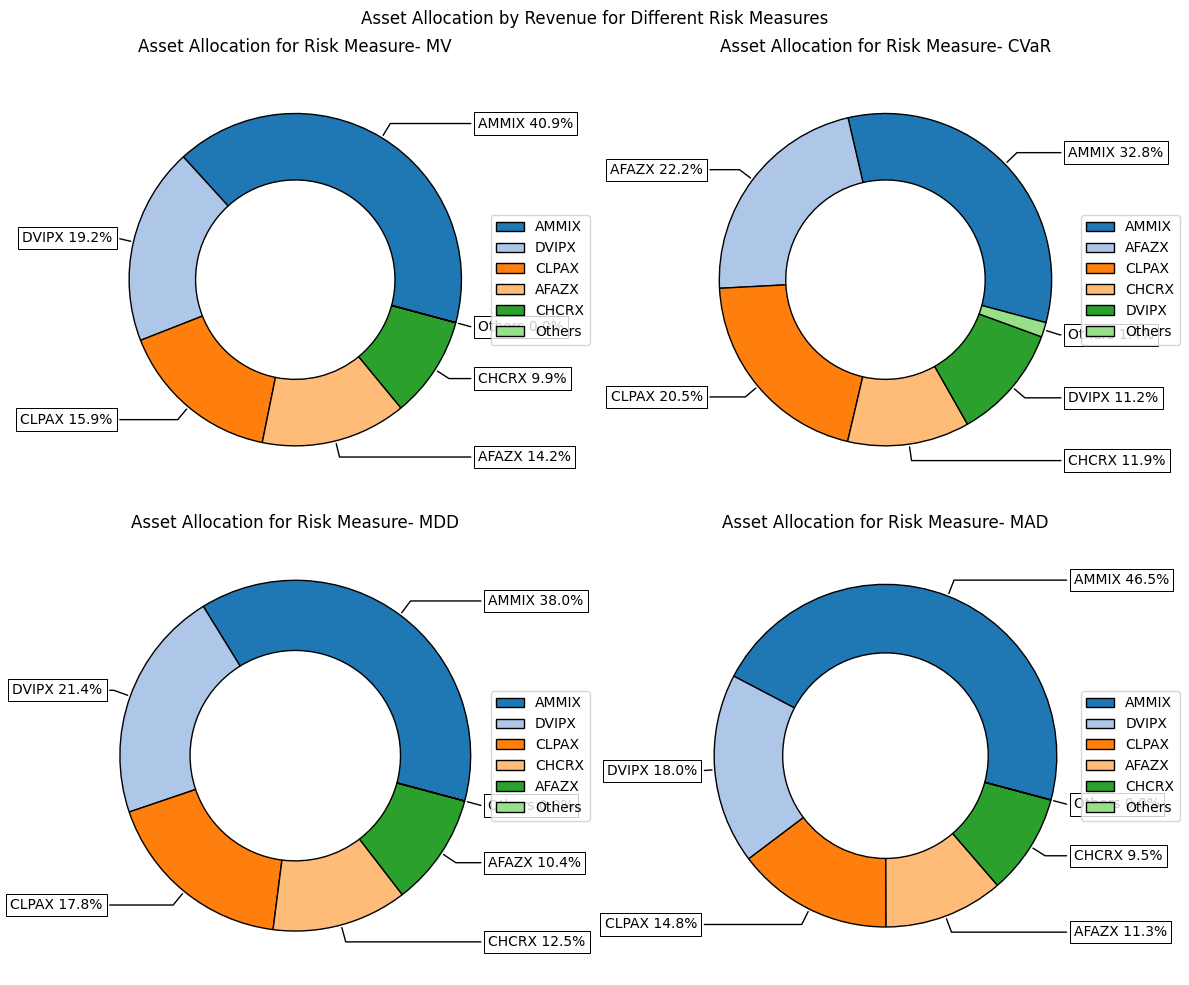

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Asset Allocation by Revenue for Different Risk Measures')

risk_measures= ['MV', 'CVaR', 'MDD', 'MAD']


for i, risk_measure in enumerate(risk_measures):
    port = rp.Portfolio(returns=Y)
    
## THESE ARGUMENTS SPECIFY THAT THE CALCULATION WAS DONE ON THE BASIS OF HISTORICAL DATA
    method_mu = 'hist'
    method_cov = 'hist'
    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

    model = 'Classic'
    rm = risk_measure
    obj = 'Sharpe'
    rf = 0

    # Portfolio optimization
    w = port.optimization(model=model, 
                          rm=rm, obj=obj, 
                          rf=rf, 
                          l=2, 
                          hist=True)
    row = i // 2
    col = i % 2
    ax = rp.plot_pie(w=w, title=f'Asset Allocation for Risk Measure- {risk_measure}', others=0.05, nrow=25, cmap="tab20", height=6, width=10, ax=axs[row, col])

plt.show()

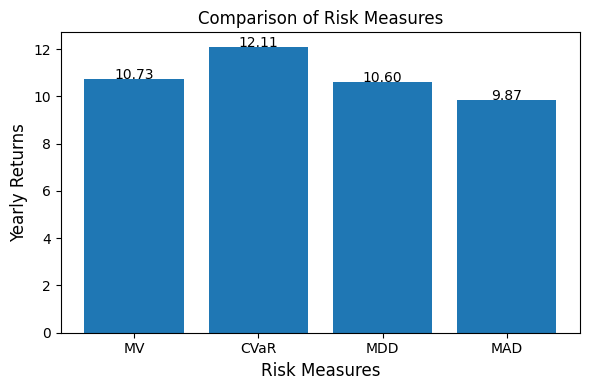

In [22]:
risk_measures= ['MV', 'CVaR', 'MDD', 'MAD']
results = {}
for i, risk_measure in enumerate(risk_measures):
   rm = risk_measure
   obj = 'Sharpe'
   # Portfolio optimization
   w = port.optimization(model=model,
                        rm=rm, obj=obj,
                        rf=rf,
                        l=2,
                        hist=True)

   portfolio_return = np.dot(np.array(w).flatten(), np.array(port.mu).flatten())
   results[risk_measure] = {'return': portfolio_return*100 * 252}

data = results
risk_measures = list(data.keys())
returns = [value['return'] for value in data.values()]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(risk_measures, returns)

ax.set_xlabel('Risk Measures', fontsize=12)
ax.set_ylabel('Yearly Returns', fontsize=12)
ax.set_title('Comparison of Risk Measures')

for i, return_value in enumerate(returns):
    ax.text(i, return_value, f'{return_value:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## FOR STANDARD MEAN VARIANCE MODEL THIS IS THE SET OF RISK- REWARD PAIRS

Text(61.95833333333333, 0.5, 'Expcted Return')

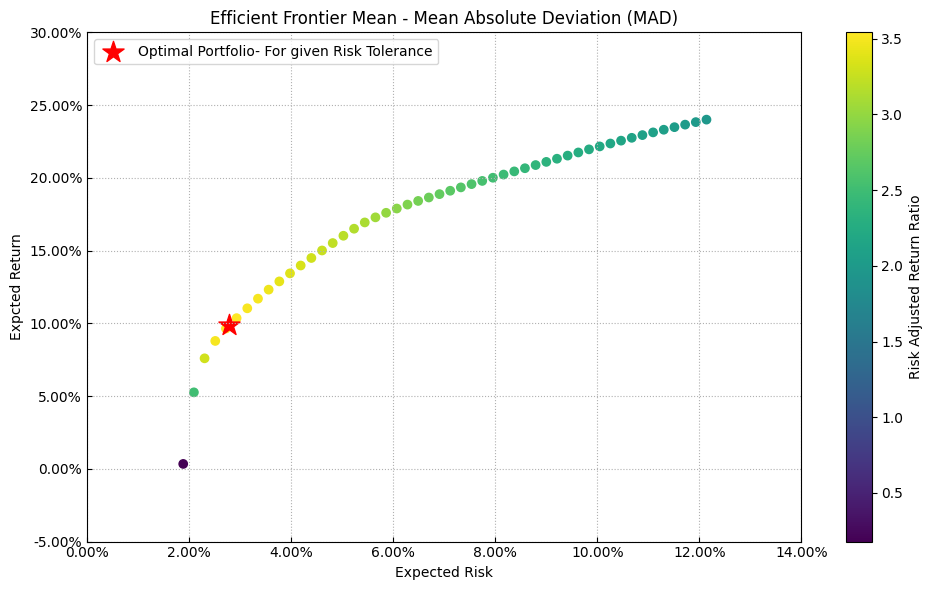

In [23]:
label = 'Optimal Portfolio- For given Risk Tolerance' 
mu = port.mu # expected returns
cov = port.cov #covariance matrix
returns = port.returns 
points = 50
frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=True)


ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)
plt.xlabel('Expected Risk')
plt.ylabel('Expcted Return')

## RUNNING A MONTE CARLO SIMULATION

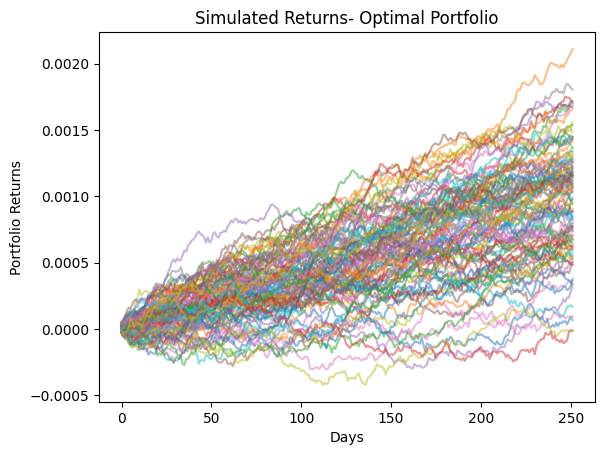

In [24]:
num_simulations = 1000
num_days = 252   

weights = np.array(w/100).T
results = np.zeros((num_simulations, num_days))

for i in range(num_simulations):
    daily_returns = np.random.multivariate_normal(np.array(mu).flatten(), np.array(cov), num_days)
    results[i, :] = np.cumsum(np.dot(weights, daily_returns.T))

results_frame = pd.DataFrame(results)

# first 100 simulations
for i in range(100):
    plt.plot(results_frame.loc[i, :], alpha=0.5)

plt.xlabel('Days')
plt.ylabel('Portfolio Returns')
plt.title("Simulated Returns- Optimal Portfolio")
plt.show()

### INSTEAD OF SOLVING THE PORTFOLIO PROBLEM NUMERICALLY, WE CAN ALSO RUN A SIMULATION ON WEIGHTS TO SEE WHAT ASSETS ALLOCATIONS CORRESPOND TO BETTER RETURNS

In [25]:
iter_log = {}  
num_iterations = 100
expected_returns = mu
sigma = cov
for i in range(num_iterations):
    weights = np.random.random(len(assets))
    weights /= np.sum(weights)  

    portfolio_return = np.sum(expected_returns * weights)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))

    iteration_result = {
        "Weights": weights.tolist(),
        "Expected Return": portfolio_return,
        "Portfolio Risk (Std. Deviation)": portfolio_stddev
    }
    iter_log[i] = iteration_result

SAMPLE IN THE LOG

In [26]:
iter_log[0]
## AND SIMILARLY FOR OTHER ASSET ALLOCATIONS

{'Weights': [0.15157109953941306,
  0.17119198169573865,
  0.11841990692293941,
  0.13819656807271608,
  0.12283890388223134,
  0.04044565886078187,
  0.15095081928544793,
  0.007726947707107354,
  0.09865811403362433],
 'Expected Return': AMMIX    0.000020
 DCGVX   -0.000175
 CLPAX    0.000062
 AFAZX    0.000132
 DVIPX    0.000068
 CSCZX   -0.000021
 CMNZX   -0.000112
 CHCRX    0.000004
 ABAEX   -0.000009
 dtype: float64,
 'Portfolio Risk (Std. Deviation)': 0.0034305074845040586}